El objetivo de este notebook es hacer un analisís exploratorio y usar el dataset para generar un  modelo simple  con el fin de estimar la tarifa nocturna ideal que debería tener una propiedad de Airbnb.

Importando las librerias necesarias

In [32]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#! pip install py-AutoClean
from AutoClean import AutoClean

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest

 


In [33]:
df=pd.read_csv("../raw_Data/listingss_airbnb.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69351 entries, 0 to 69350
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              69351 non-null  int64  
 1   name                            69330 non-null  object 
 2   host_id                         69351 non-null  int64  
 3   host_name                       69346 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   69351 non-null  object 
 6   latitude                        69351 non-null  float64
 7   longitude                       69351 non-null  float64
 8   room_type                       69351 non-null  object 
 9   price                           69351 non-null  int64  
 10  minimum_nights                  69351 non-null  int64  
 11  number_of_reviews               69351 non-null  int64  
 12  last_review                     

Observamos que en el datafame, las columnas license y neigbourhood group estan vacias, procedemos a eliminarlas.

In [35]:
df=df.drop(['license','neighbourhood_group'],axis=1)

Observando el numero de valores unicos por columna

In [36]:
df.nunique()

id                                69351
name                              67029
host_id                           45229
host_name                         13043
neighbourhood                        33
latitude                          28647
longitude                         38106
room_type                             4
price                              1414
minimum_nights                      124
number_of_reviews                   434
last_review                        2728
reviews_per_month                   841
calculated_host_listings_count       77
availability_365                    366
number_of_reviews_ltm               157
dtype: int64

Observando el numero de valores nulos por columna

In [37]:
df.isnull().sum()

id                                    0
name                                 21
host_id                               0
host_name                             5
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       16780
reviews_per_month                 16780
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
dtype: int64

**Analisis de variables numericas y categoricas**

Seleccionaremos las variables numéricas que vamos a estudiar por su relevancia para el caso:
* Price: Precio diario en moneda local
* Minimun Nights : Cantidad minima de noches para la reserva
* Number Of Reviews : numero total de reviews
* Last review (Nos interesa la fecha en la que fue hecha la ultima review de la habitacion de la cual queremos estudiar su precio).
* Reviews Per Month : numbero de reviews por mes 
* calculated_host_listings_count : cuantas ofertas en total tiene disponibles el oferente de esta estadía en el dataset.
* availability_365
* number_of_reviews_ltm


In [38]:
columnas_numericas = df.select_dtypes(include='number').columns
columnas_numericas


Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')

Describiendo columnas numericas.

In [39]:
df[columnas_numericas].describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,6.935100e+04,6.935100e+04,69351.000000,69351.000000,69351.000000,69351.000000,69351.000000,52571.000000,69351.000000,69351.000000,69351.000000
mean,1.373703e+17,1.242124e+08,51.509544,-0.128489,177.208822,5.997505,17.537051,0.882593,11.987498,108.520266,4.734438
std,2.651479e+17,1.377104e+08,0.049182,0.100957,412.823024,25.709514,40.410763,1.274510,37.148839,132.821088,12.032502
min,1.391300e+04,4.775000e+03,51.272480,-0.523600,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.810090e+07,1.870718e+07,51.483140,-0.189520,55.000000,1.000000,1.000000,0.120000,1.000000,0.000000,0.000000
50%,3.395467e+07,6.010350e+07,51.513600,-0.126200,100.000000,2.000000,4.000000,0.430000,1.000000,32.000000,0.000000
75%,5.265645e+07,1.960405e+08,51.539710,-0.068550,180.000000,4.000000,16.000000,1.080000,4.000000,228.000000,5.000000
max,7.123951e+17,4.788540e+08,51.708930,0.305150,25000.000000,1125.000000,1141.000000,51.330000,285.000000,365.000000,660.000000


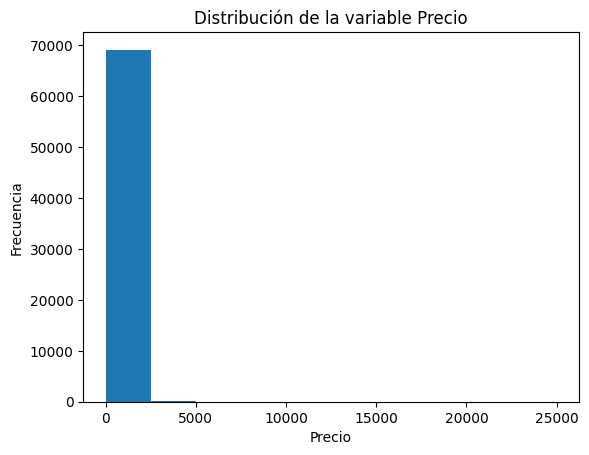

In [40]:

plt.hist(df['price'], bins=10) 
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable Precio')
plt.show()

Estudiando los precios por debajo del percentil 75% para observar mejor como se distribuyen en el dataset.

In [41]:
# para ver mejor como se distribuyen los valores de la variable precio por debajo del percentil 75% filtramos obtenemos
# un dataset filtrado 

df_per_75=df[df['price']<180]
df_resto=df[df['price']>180]




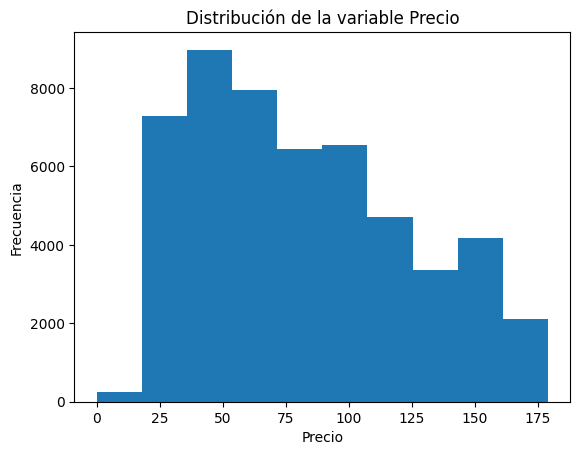

In [42]:
plt.hist(df_per_75['price'], bins=10) 
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable Precio')
plt.show()

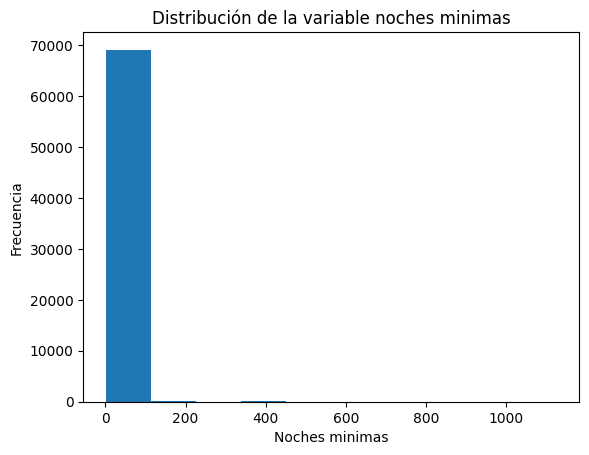

In [43]:

plt.hist(df['minimum_nights'], bins=10) 
plt.xlabel('Noches minimas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable noches minimas')
plt.show()

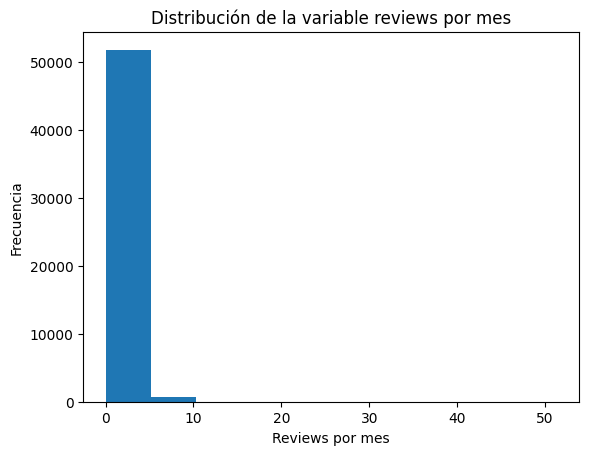

In [44]:
plt.hist(df['reviews_per_month'], bins=10) 
plt.xlabel('Reviews por mes')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable reviews por mes')
plt.show()

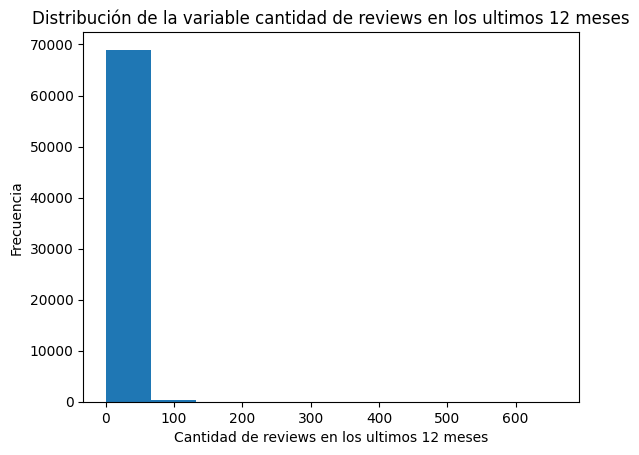

In [45]:
plt.hist(df['number_of_reviews_ltm'], bins=10) 
plt.xlabel('Cantidad de reviews en los ultimos 12 meses')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable cantidad de reviews en los ultimos 12 meses')
plt.show()

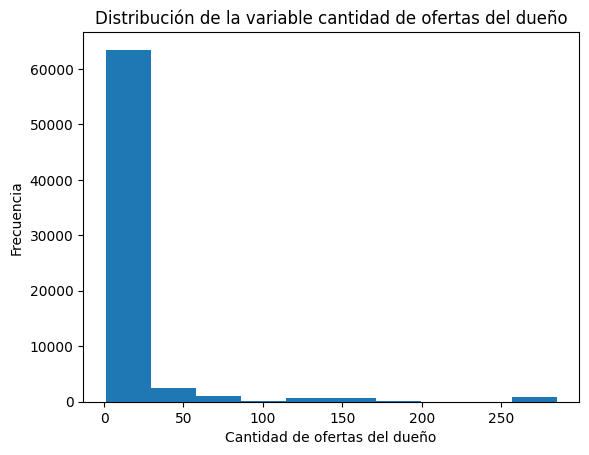

In [46]:
plt.hist(df['calculated_host_listings_count'], bins=10) 
plt.xlabel('Cantidad de ofertas del dueño')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable cantidad de ofertas del dueño')
plt.show()

Observamos que se encuentran muchos valores atipicos en las variables numericas, sin embargo no queremos deshacernos de estos valores atipicos por que pueden ser importantes a la hora de generar nuestros pronosticos de la variable precio, por lo cual dejaremos tal cual por ahora.


Explorando variables categoricas.

El tipos de espacio disponible para rentar mas abundante son las casas/apartamentos completos con un total de 41224 ofertas, representando un 59,4% del total de las ofertas, seguido de habitaciones privadas con un 39.6% de las ofertas.

In [47]:
#Contando los valores distintos de la columna room_type para saber cuantos tipos de estancias hay disponibles
df['room_type'].value_counts()

room_type
Entire home/apt    41224
Private room       27479
Shared room          404
Hotel room           244
Name: count, dtype: int64

In [48]:
#calculando el porcentaje de participacion de cada uno de los  tipos de estancias disponibles
df['room_type'].value_counts()/df['room_type'].value_counts().sum()*100

room_type
Entire home/apt    59.442546
Private room       39.623077
Shared room         0.582544
Hotel room          0.351833
Name: count, dtype: float64

**El barrio con mas ofertas disponibles es el Westminster**

In [49]:
#Contando los valores distintos de la columna neighbourhood para saber cuantos tipos de estancias hay disponibles
df['neighbourhood'].value_counts()

neighbourhood
Westminster               7763
Tower Hamlets             5595
Hackney                   5168
Camden                    4707
Kensington and Chelsea    4612
Southwark                 3968
Islington                 3790
Lambeth                   3719
Wandsworth                3473
Hammersmith and Fulham    2996
Brent                     2068
Lewisham                  2016
Haringey                  1898
Newham                    1682
Barnet                    1611
Ealing                    1553
Greenwich                 1514
Waltham Forest            1322
Merton                    1114
Richmond upon Thames      1108
Hounslow                  1078
Croydon                   1066
Hillingdon                 714
Redbridge                  669
Enfield                    617
Kingston upon Thames       609
Bromley                    594
Harrow                     444
Barking and Dagenham       433
City of London             424
Bexley                     411
Havering                 

In [50]:
porcentaje_de_ocurrencias=df['neighbourhood'].value_counts()/df['neighbourhood'].value_counts().sum()*100
porcentaje_de_ocurrencias

neighbourhood
Westminster               11.193782
Tower Hamlets              8.067656
Hackney                    7.451947
Camden                     6.787213
Kensington and Chelsea     6.650229
Southwark                  5.721619
Islington                  5.464954
Lambeth                    5.362576
Wandsworth                 5.007859
Hammersmith and Fulham     4.320053
Brent                      2.981932
Lewisham                   2.906952
Haringey                   2.736803
Newham                     2.425344
Barnet                     2.322966
Ealing                     2.239333
Greenwich                  2.183098
Waltham Forest             1.906245
Merton                     1.606321
Richmond upon Thames       1.597670
Hounslow                   1.554412
Croydon                    1.537108
Hillingdon                 1.029545
Redbridge                  0.964658
Enfield                    0.889677
Kingston upon Thames       0.878142
Bromley                    0.856513
Harrow        

**El vecindario con mas espacios disponibles en oferta es el Westminster**

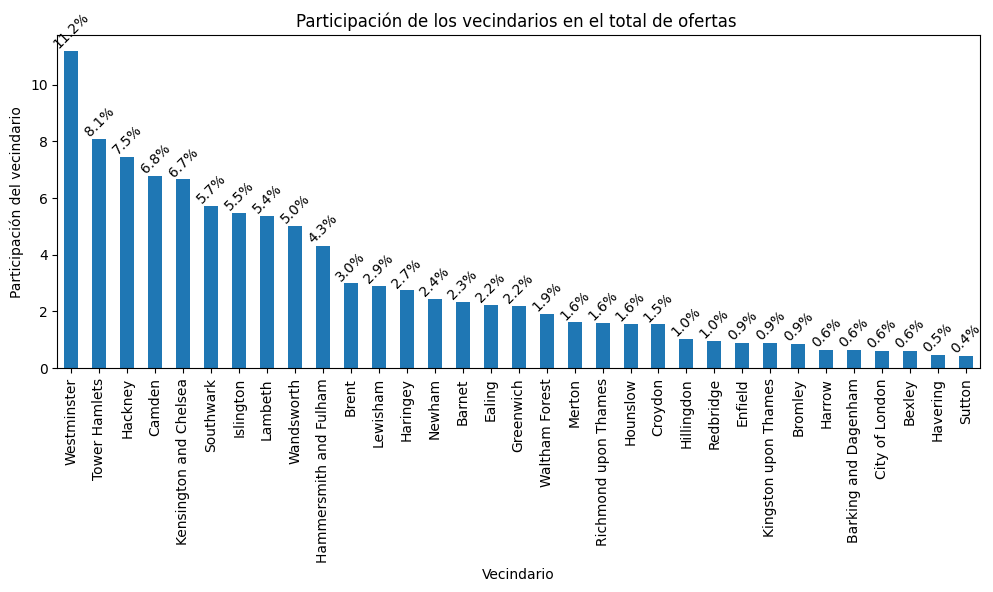

In [51]:
plt.figure(figsize=(10, 6))
bar_plot = porcentaje_de_ocurrencias.plot(kind='bar')
plt.xlabel('Vecindario')
plt.ylabel('Participación del vecindario')
plt.title('Participación de los vecindarios en el total de ofertas ')
plt.xticks(rotation=90)
plt.tight_layout()

for index, value in enumerate(porcentaje_de_ocurrencias):
    bar_plot.text(index, value, f'{value:.1f}%', ha='center', va='bottom',rotation=45)

plt.show()


Estudiando la correlacion entre las variables numericas de interes mediante un mapa de correlación.
Observamos que no existe a primera vista una correlacion muy clara para explicar la variable precio.

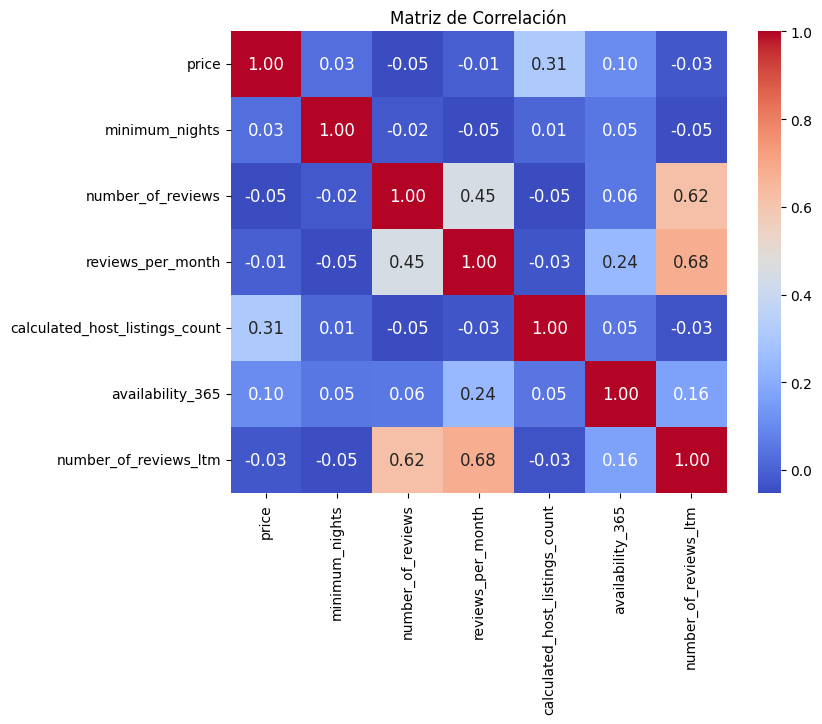

In [52]:
columnas_numericas = ['price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm']

df_numericas = df[columnas_numericas]

matriz_correlacion = df_numericas.corr()

# Creando el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 12})
plt.title('Matriz de Correlación')
plt.show()

Las columnas number_of_reviews_ltm, number_of_reviews y reviews_per_month estan fuertemente correlacionadas entre si, podemos quedarnos con una sola, que en este caso sera la que tiene menos valores faltantes que es number_of_Reviews_ltm.

In [53]:
df=df.drop(['number_of_reviews','reviews_per_month'],axis=1)

Observando el precio promedio por vecindario, vemos que Kensignton and Chelsea es el barrio con mayor precio promedio para los espacios disponibles , seguido de wetminster. Sin embargo esta medida puede ser engañosa porque pueden haber unas cuantas propiedades disponibles con precios muy altos que esten alterando estos resultados, deberemos verificar eso mas adelante calculando ademas de la media la mediana

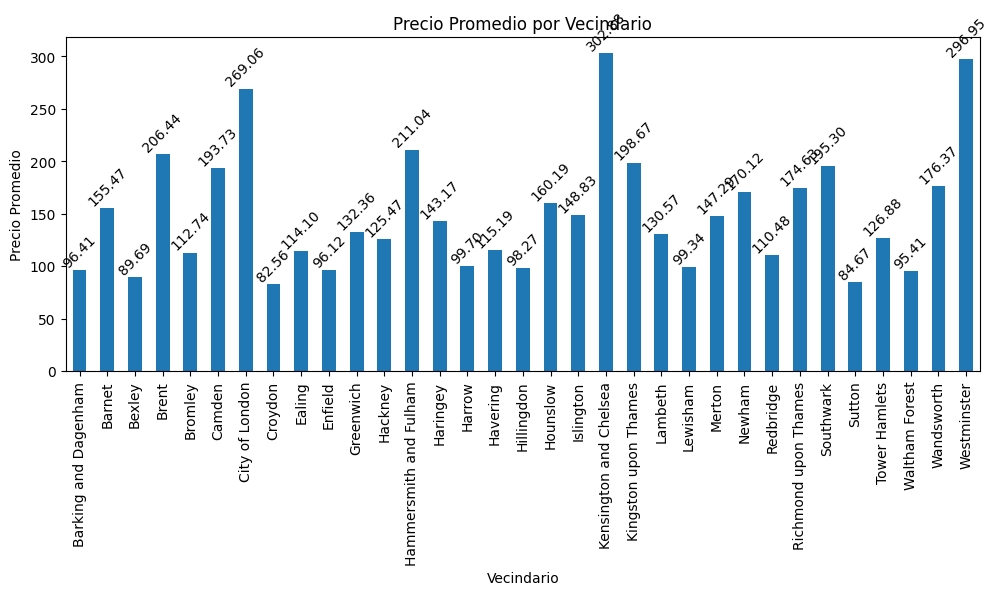

In [54]:
promedio_precio_por_vecindario = df.groupby('neighbourhood')['price'].mean()
plt.figure(figsize=(10, 6))
bar_plot = promedio_precio_por_vecindario.plot(kind='bar')
plt.xlabel('Vecindario')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por Vecindario')
plt.xticks(rotation=90)
plt.tight_layout()

# Agregar los precios promedios encima de las barras
for index, value in enumerate(promedio_precio_por_vecindario):
    bar_plot.text(index, value, f'{value:.2f}', ha='center', va='bottom',rotation=45)

plt.show()


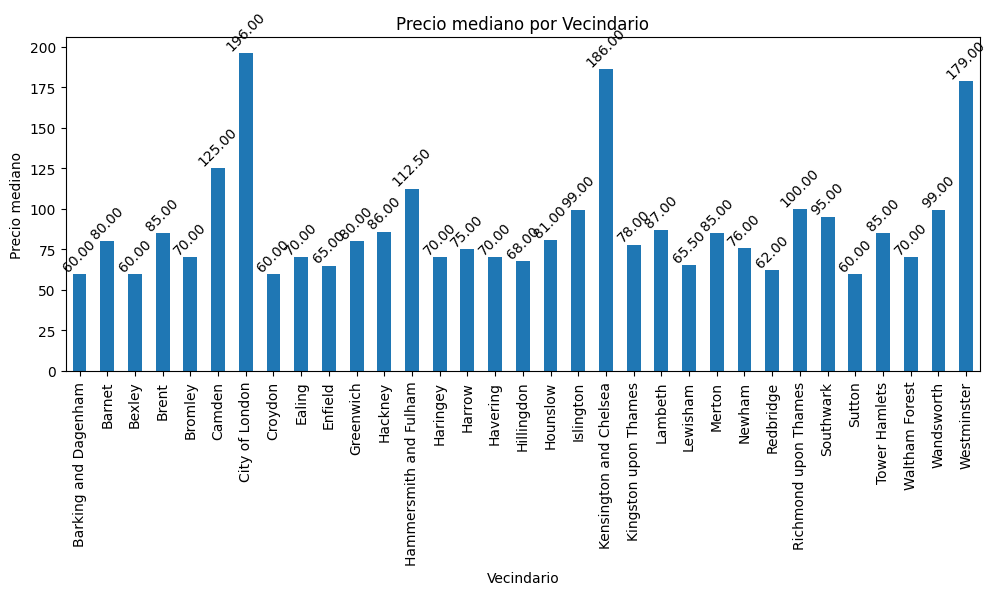

In [55]:
precio_mediano_por_vecindario = df.groupby('neighbourhood')['price'].median()
plt.figure(figsize=(10, 6))
bar_plot = precio_mediano_por_vecindario.plot(kind='bar')
plt.xlabel('Vecindario')
plt.ylabel('Precio mediano')
plt.title('Precio mediano por Vecindario')
plt.xticks(rotation=90)
plt.tight_layout()

# Agregar los precios promedios encima de las barras
for index, value in enumerate(precio_mediano_por_vecindario):
    bar_plot.text(index, value, f'{value:.2f}', ha='center', va='bottom',rotation=45)

plt.show()

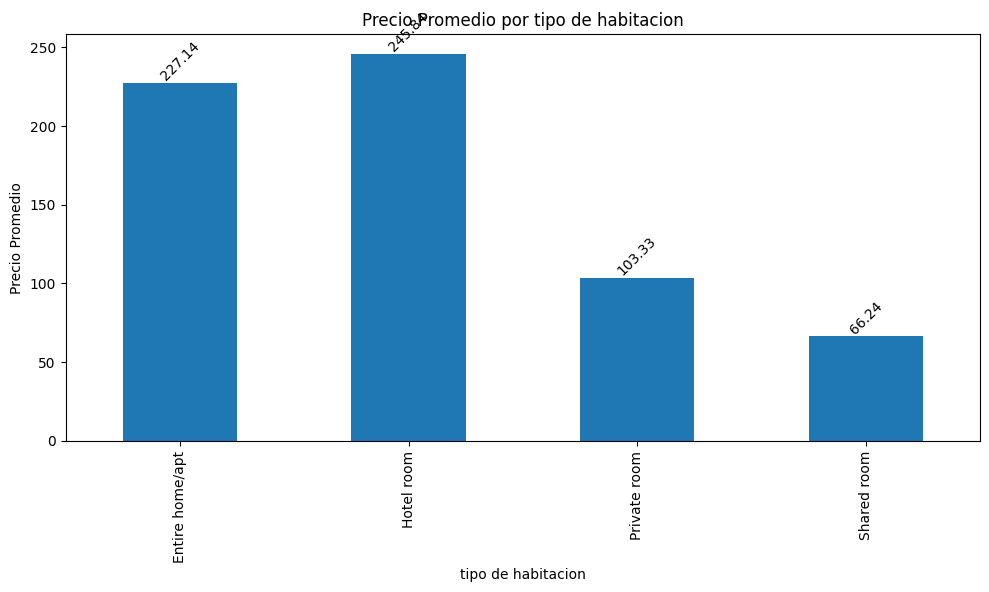

In [56]:
promedio_precio_por_tipo = df.groupby('room_type')['price'].mean()
plt.figure(figsize=(10, 6))
bar_plot = promedio_precio_por_tipo.plot(kind='bar')
plt.xlabel('tipo de habitacion')
plt.ylabel('Precio Promedio')
plt.title('Precio Promedio por tipo de habitacion')
plt.xticks(rotation=90)
plt.tight_layout()

# Agregar los precios promedios encima de las barras
for index, value in enumerate(promedio_precio_por_tipo):
    bar_plot.text(index, value, f'{value:.2f}', ha='center', va='bottom',rotation=45)

plt.show()

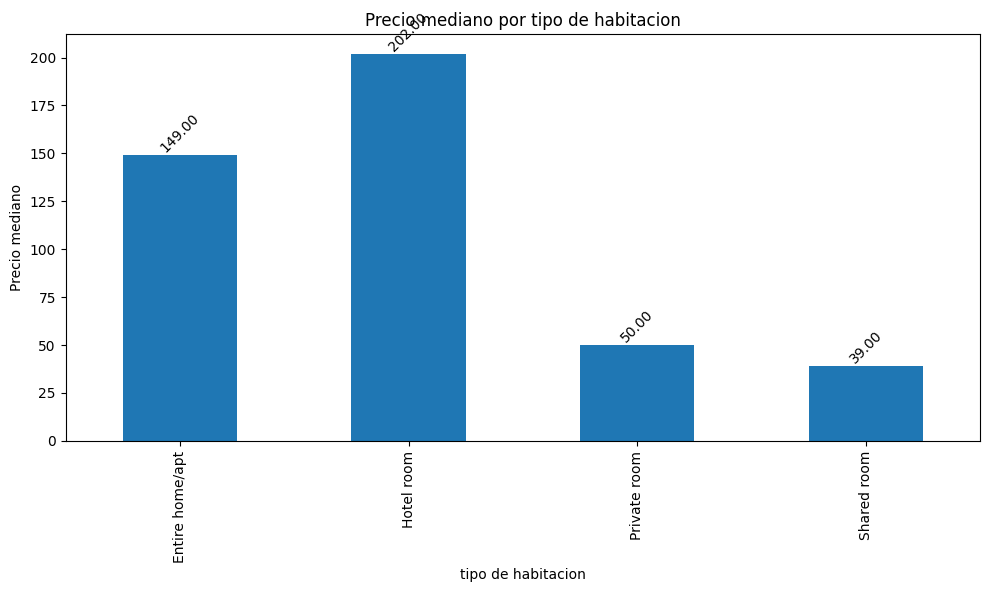

In [57]:
mediana_precio_por_tipo = df.groupby('room_type')['price'].median()
plt.figure(figsize=(10, 6))
bar_plot = mediana_precio_por_tipo.plot(kind='bar')
plt.xlabel('tipo de habitacion')
plt.ylabel('Precio mediano')
plt.title('Precio mediano por tipo de habitacion')
plt.xticks(rotation=90)
plt.tight_layout()

# Agregar los precios promedios encima de las barras
for index, value in enumerate(mediana_precio_por_tipo):
    bar_plot.text(index, value, f'{value:.2f}', ha='center', va='bottom',rotation=45)

plt.show()

Transformando el tipo de dato de la columna last_review a tipo datetime


In [58]:
df['last_review'] = pd.to_datetime(df['last_review'])


En esta ocasión se usara la estrategia de dividir el dataset en 3 datasets distintos para desarrollar modelos para predecir el precio de cada una de las 4 categorias de estancias:
* Apartamento - casa completa
* habitación de hotel
* Habitación compartida
* Habitación privada

Guardando los datasets separados por si necesitamos estudiarlos cada uno independientemente para el modelado.

Vamos a preparar el dataset eliminando las columnas que no nos interesan para la regresion dado que no nos proporcionan informacion relevante al respecto.

La variable last_review puede ser interesante para el analisis pero dado que contiene valores nulos, para este primer ejercicio la eliminaremos , posteriormente podriamos volver a recuperarla.


In [59]:
df.drop(['id','name','host_id','host_name','last_review'],axis=1,inplace=True)

Guardando el dataset que vamos a emplear para el analisis de regresión.

In [60]:
df.to_csv('../preprocesados/modeling_features_clean.csv',index=False)

In [61]:
df_apto_casas=df[df['room_type']=='Entire home/apt']
df_hotel_rooms=df[df['room_type']=='Hotel room']
df_private_rooms=df[df['room_type']=='Private room']
df_shared_rooms=df[df['room_type']=='Shared room']

df_apto_casas.to_csv('../datos_separados/datos_apto_casas.csv', index=False)
df_hotel_rooms.to_csv('../datos_separados/datos_hotel_room.csv', index=False)
df_private_rooms.to_csv('../datos_separados/datos_private_room.csv', index=False)
df_shared_rooms.to_csv('../datos_separados/datos_shared_rooms.csv', index=False)
